In [2]:
import os
import sys
lib_path = os.path.abspath(os.path.join(os.path.abspath(''), 'functions/'))
sys.path.append(lib_path)
# need to append our functions dir to the path! 
import dalecLoad as dl

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import spectralConv
import seaborn as sns

from scipy.signal import savgol_filter


In [2]:
# using load_DALEC_dir might lead to v large files all being loaded into memory all at once
# therefore, perhaps better to be smarter than this!
logs_81_84 = dl.load_DALEC_dir('data/logs_81_84/', file_names=['LOG_0082.dtf'])

loading ... data/logs_81_84/LOG_0082.dtf


KeyboardInterrupt: 

In [ ]:
logs_81_84

In [32]:
log_81_re = dl.resampleMultiLog(logs_81_84, freq='5min')

In [33]:
spect_w = dl.load_DALEC_spect_wavelengths('data/logs_81_84/LOG_0081.dtf')
ug = dl.uniform_grid_spectra_multi(log_81_re, spect_w, resample_to_SDs=False)


<AxesSubplot:xlabel='Wavelength', ylabel='Rrs_median'>

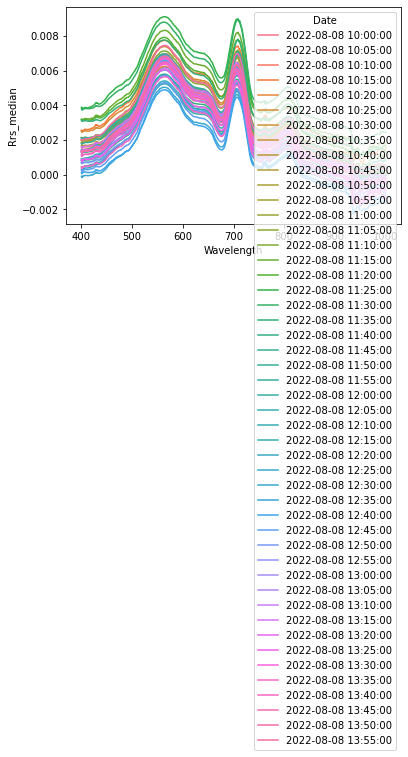

In [34]:
sns.lineplot(data=ug, x='Wavelength', y='Rrs_median', hue='Date')

# Process multiple files and save to csv for Dalin's processing

In [5]:
spect_w = dl.load_DALEC_spect_wavelengths('data/logs_81_84/LOG_0081.dtf')

savWindowLen = 21 # 21 nm is recommeneded by Jiang et al., 2020, ISPRS.
                  # https://doi.org/10.1016/j.isprsjprs.2020.05.003
savPolyOrder = 4
# Dalin doesn't specify in the paper what filter order, but I think he uses R and 4 appears to be the deafult  


outputFileName = 'TEST.csv'

DALEC_files = []
for file in os.listdir('data/logs_81_84/'):
    if file.endswith(".dtf"):
        DALEC_files.append(file)

for i, filen in enumerate(DALEC_files):
    # load log
    log = dl.load_DALEC_dir('data/logs_81_84/', file_names=[filen])
    # resample to 5 min intervals
    log_re = dl.resampleMultiLog(log, freq='5min')
    # regrid and calc Rrs
    df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
    # reformat
    df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
    df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
    df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
    df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
    # apply savgol filter
    dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                     axis=1, result_type='broadcast')
    
    Rcode_path = os.path.abspath(os.path.join(os.path.abspath(''), 'R-code/'))

    outputPath = os.path.join(Rcode_path, 'data/' + outputFileName)
    if i == 0:
        dfSmooth.to_csv(outputPath, mode='w')
    else:
        dfSmooth.to_csv(outputPath, mode='a', header=False) # use append mode to add all data to one csv

loading ... data/logs_81_84/LOG_0084.dtf
loading ... data/logs_81_84/LOG_0082.dtf
loading ... data/logs_81_84/LOG_0081.dtf
loading ... data/logs_81_84/LOG_0083.dtf


In [5]:
# more work needed!!!!
# think only the dateOnly thing doesn't work, so fine for my work atm

def reloadDeltaCorr(filepath, keepFlags=0, onlyRrs=True, dropFlag=False, dateOnly=False):
    '''
    loads csv file generated by Dalin's R code into pandas df
    keepFlags selects which DeltaCor_flag should be accepted
        eg. keepFlags=[0, 1] will keep good data AND data with Oxygen aborption flag
        flags:
            0: good data
            1: Oxygen aborption at 760nm is too strong, may influence the Rrs shape
            2: out of the training range of the method
            3: extremely turbid, algae bloom, floating materials, high TSM waters
            4: negative results between 400-700 nm after delta correction
    onlyRrs drops all other columns except the output Rrs columns
    '''
    df = pd.read_csv(filepath)
    
    if type(keepFlags) is not list:
        keepFlags = [keepFlags]
    
    df = df[df['DeltaCor_flag'].isin(keepFlags)]
    
    if onlyRrs:
        df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'RHW', 'Delta'], 
               axis=1, inplace=True)
    if dropFlag:
        df.drop(['DeltaCor_flag'], 
               axis=1, inplace=True)
        
    df.rename(columns={'Rrs400.1': 'Rrs400'}, inplace=True)
    #df['id'] = df.index
    df_long = pd.wide_to_long(df, 'Rrs', i='Date', j='Wavelength')
    
    df_long.sort_index(inplace=True)
    

    
    # currently dateOnly doesn't do what I want! need to rename the index! 

    df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)),
                                               df_long.index.get_level_values(level=1)])
    
    if dateOnly:
        # resample to daily 
        df_long = df_long.groupby([pd.Grouper(freq='1d', level=0)] + ['Wavelength']).median()
        df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)).date,
                                                   df_long.index.get_level_values(level=1)])
        df_long.index.names = ['Date', 'Wavelength']
    
    return df_long

In [10]:
# load delta corrected spectra
dalecDelta = reloadDeltaCorr('~/Documents/StirlingUni/Project/DALEC_processing/R-code/data/TEST_DeltaCor_Jiang.csv',
                            )

In [11]:
dalecDelta.reset_index(inplace=True)
dalecDelta['date'] = dalecDelta.Date.dt.date

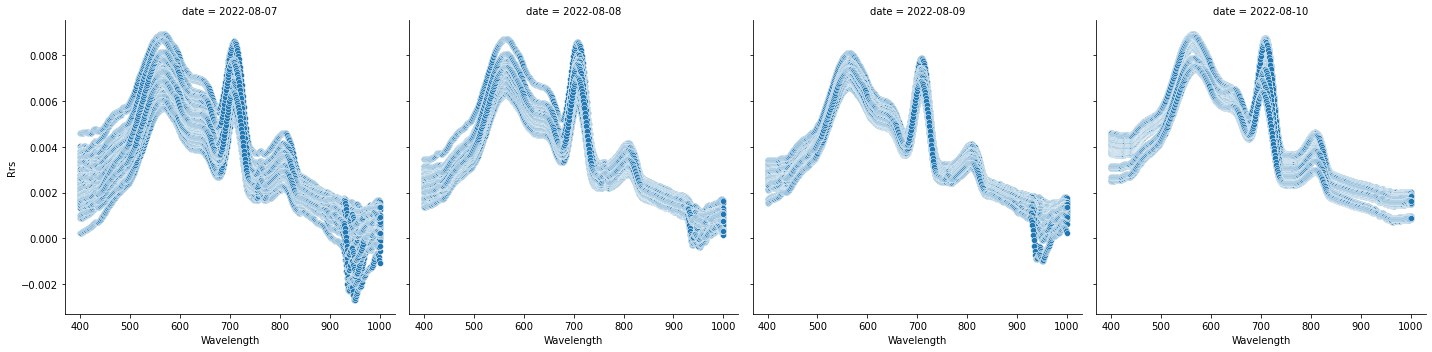

In [26]:
sns.relplot(data=dalecDelta, x='Wavelength', y='Rrs', col='date')

In [24]:
dalecDelta.Date.dt.date

0         2022-08-07
1         2022-08-07
2         2022-08-07
3         2022-08-07
4         2022-08-07
             ...    
115387    2022-08-10
115388    2022-08-10
115389    2022-08-10
115390    2022-08-10
115391    2022-08-10
Name: Date, Length: 115392, dtype: object

# Now try and saving and loading all the data...

In [3]:
spect_w = dl.load_DALEC_spect_wavelengths('data/calibrated_full/2022/LOG_0071.dtf')

savWindowLen = 21 # 21 nm is recommeneded by Jiang et al., 2020, ISPRS.
                  # https://doi.org/10.1016/j.isprsjprs.2020.05.003
savPolyOrder = 4
# Dalin doesn't specify in the paper what filter order, but I think he uses R and 4 appears to be the deafult  


outputFileName = '2022.csv'

DALEC_files = []
for file in os.listdir('data/calibrated_full/2022_good_files/'):
    if file.endswith(".dtf") and file not in ['LOG_0098.dtf',
                                              'LOG_0099.dtf'
                                              'LOG_0100.dtf'
                                              'LOG_0107.dtf']:
        DALEC_files.append(file)

for i, filen in enumerate(DALEC_files):
    # load log
    log = dl.load_DALEC_dir('data/calibrated_full/2022_good_files/', 
                            file_names=[filen])
    print('loaded. Now resampling, regridding etc... \n')
    # resample to 5 min intervals
    log_re = dl.resampleMultiLog(log, freq='5min')
    # regrid and calc Rrs
    df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
    # reformat
    df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
    df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
    df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
    df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
    # apply savgol filter
    dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                     axis=1, result_type='broadcast')
    
    Rcode_path = os.path.abspath(os.path.join(os.path.abspath(''), 'R-code/'))

    outputPath = os.path.join(Rcode_path, 'data/' + outputFileName)
    if i == 0:
        dfSmooth.to_csv(outputPath, mode='w')
    else:
        dfSmooth.to_csv(outputPath, mode='a', header=False) # use append mode to add all data to one csv

loading ... data/calibrated_full/2022_good_files/LOG_0076.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0100.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0088.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0080.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0097.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0084.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0075.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0087.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0071.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_fil

In [1]:
# load delta corrected spectra
dalecDelta = reloadDeltaCorr('~/Documents/StirlingUni/Project/DALEC_processing/R-code/data/2023_DeltaCor_Jiang.csv',
                             keepFlags=[0, 1, 2, 3, 4], )

NameError: name 'reloadDeltaCorr' is not defined

In [13]:
dalecDelta.reset_index(inplace=True)
dalecDelta['date'] = dalecDelta.Date.dt.date

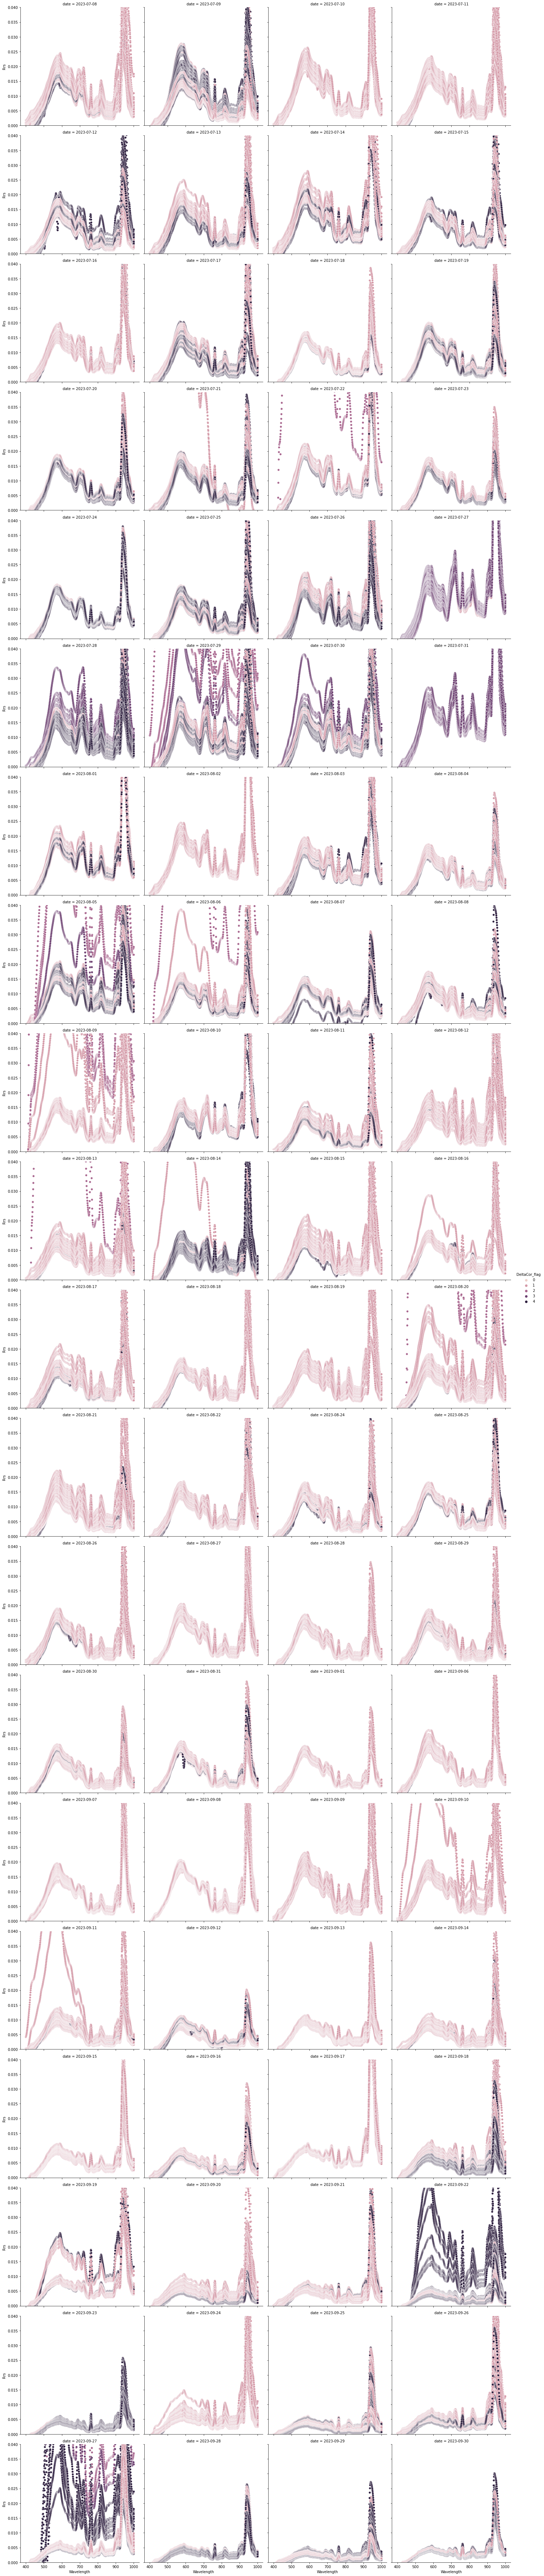

In [16]:
g = sns.relplot(data=dalecDelta, x='Wavelength', y='Rrs', col='date', col_wrap=4, hue='DeltaCor_flag')
g.set(ylim=(0, 0.04))

In [6]:
# load delta corrected spectra
dalecDelta_22 = reloadDeltaCorr('~/Documents/StirlingUni/Project/DALEC_processing/R-code/data/2022_DeltaCor_Jiang.csv',
                             keepFlags=[0, 1, 2, 3, 4], )

In [7]:
dalecDelta_22.reset_index(inplace=True)
dalecDelta_22['date'] = dalecDelta_22.Date.dt.date

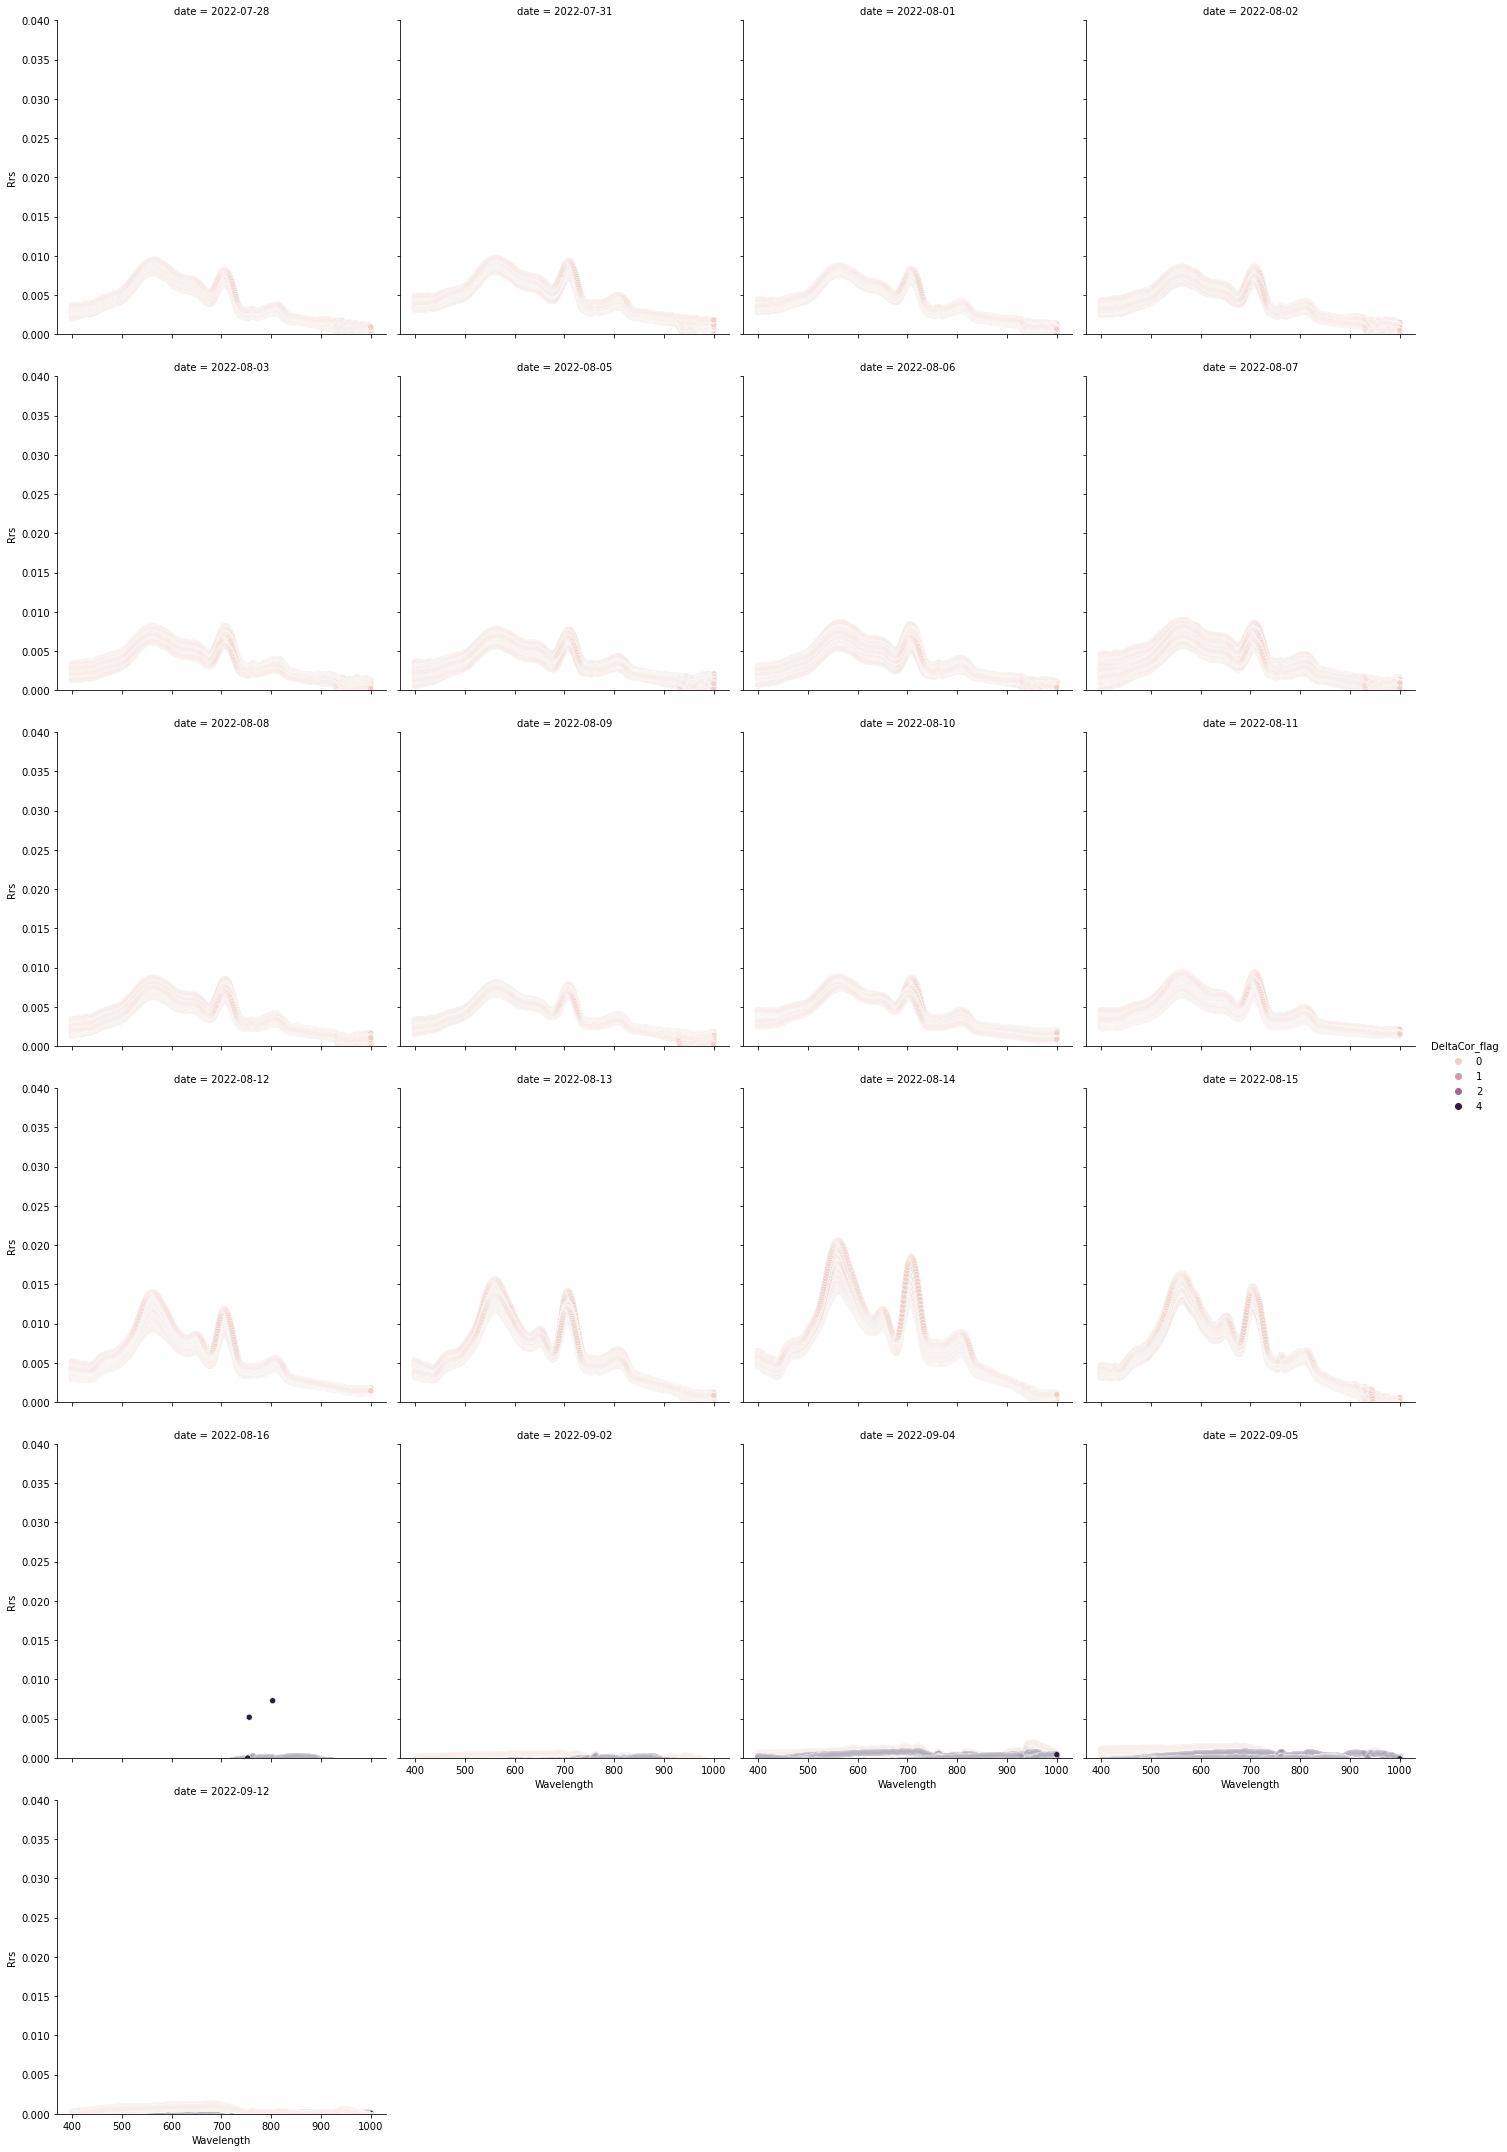

In [8]:
g = sns.relplot(data=dalecDelta_22, x='Wavelength', y='Rrs', col='date', col_wrap=4, hue='DeltaCor_flag')
g.set(ylim=(0, 0.04))